# Automatic Patent Classification

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.style.use("classic")
sns.set()
from time import time

## Pre-processing...

### Importing data into pandas.DataFrame

In [2]:
### Importing data into pandas.DataFrame
# LOAD DATA DIRECTLY FROM .CSV INTO PYTHON_LIST()

t0 = time()
print('Importing data...')
try:
    dataset = open('dataset_ipc_first.csv', 'r', encoding='latin-1')
except:
    dataset = open('./output/dataset_ipc_first.csv', 'r', encoding='latin-1')
else:
    pass

if dataset:
    IPC_level1_classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    X_title, X_resume, y = [], [], []
    header = dataset.readline()
    if header[:-1] == 'title|resume|ipc':
        for line in dataset:
            line = line[:-1].split('|')
            if line[2][0:1] in IPC_level1_classes:
                X_title.append(line[0])  # title
                X_resume.append(line[1]) # resume
                y.append(line[2][0:1])   # only first level IPC class (A..H)
    print('Number of occurences on X_title: ', len(X_title))
    print('Number of occurences on X_resume: ', len(X_resume))
    print('Number of occurences on y: ', len(y))
    categories = pd.DataFrame(y, columns = ['ipc_level1'])
print('done in %0.3fs.' % (time() - t0))


## REDUCE SAMPLE SIZE
# reducing number of rows to 5000
# X_title = X_title[0:4999]
# X_resume = X_resume[0:4999]
# y = y[0:4999]
# categories = categories[0:4999]
# print('Number of samples has been reduced to 5.000 during test phase. Must comment this section to run a valid experiment')

Importing data...
Number of occurences on X_title:  347032
Number of occurences on X_resume:  347032
Number of occurences on y:  347032
done in 1.402s.


### Analyzing data

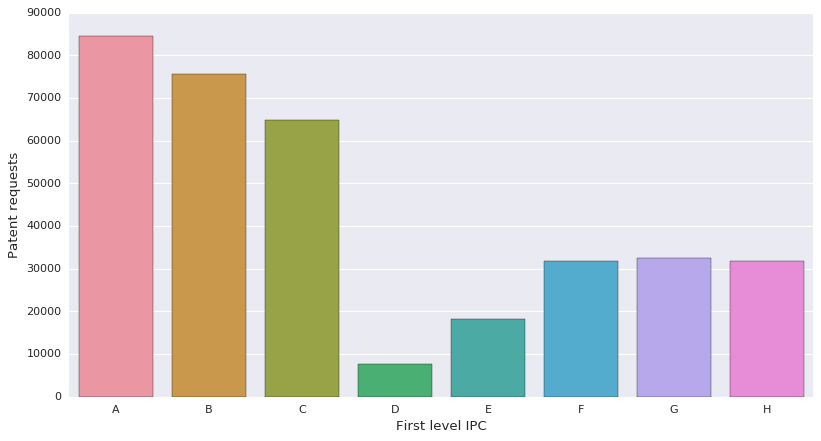

Total count of patent requests:  347032

Best guess is the category: A    0.243577
Name: ipc_level1, dtype: float64


In [3]:
### first look on data
plt.figure(figsize=(12,6))
ax = sns.countplot(x="ipc_level1", data=categories.sort_values('ipc_level1'))
plt.ylabel('Patent requests', fontsize=12)
plt.xlabel('First level IPC', fontsize=12)
plt.xticks(rotation='horizontal')
plt.show()
print('Total count of patent requests: ', len(categories))
print()
best_guess = categories.ipc_level1.value_counts().nlargest(n=1) / len(categories)
print('Best guess is the category: %s' % best_guess)

## Extracting features...

### Vectorization (Term Frequency - Inverted Document Frequency - TF-IDF)

In [4]:
### Vectorization
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer

t0 = time()
print('Extracting features...')
vec = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 2), max_df = .95, min_df = 1, sublinear_tf=True)

X_title_features = vec.fit_transform(X_title)
print('Title vector matrix shape: ', X_title_features.shape)

X_resume_features = vec.fit_transform(X_resume)
print('Resume vector matrix shape: ', X_resume_features.shape)

print('done in %0.3fs.' % (time() - t0))

Extracting features...
Title vector matrix shape:  (347032, 615723)
Resume vector matrix shape:  (347032, 4126367)
done in 176.060s.


### Reducing deminsionality

In [5]:
### Reducing deminsionality with SVD
from sklearn.decomposition import TruncatedSVD

t0 = time()
print('Selecting most relevant features...')

svd = TruncatedSVD(n_components = 200)
X_title_svd = svd.fit_transform(X_title_features)
print('Title most relevant features matrix shape: ', X_title_svd.shape)

svd = TruncatedSVD(n_components = 800)
X_resume_svd = svd.fit_transform(X_resume_features)
print('Resume most relevant features matrix shape: ', X_resume_svd.shape)

print('done in %0.3fs.' % (time() - t0))

Selecting most relevant features...
Title most relevant features matrix shape:  (347032, 200)
Resume most relevant features matrix shape:  (347032, 800)
done in 5291.438s.


### Categories encoding

In [6]:
### Encoding each category into one exclusive integer
from sklearn.preprocessing import LabelEncoder

t0 = time()
print('Encoding labels...')
l_enc = LabelEncoder()
y_encoded = l_enc.fit_transform(y)
print('Encoded classes: ', l_enc.classes_)
print('done in %0.3fs.' % (time() - t0))

Encoding labels...
Encoded classes:  ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H']
done in 0.075s.


## Spliting train and test samples...

In [7]:
from sklearn.model_selection import train_test_split

t0 = time()
print('Creating sampling...')
X_concatenated = np.concatenate((X_title_svd, X_resume_svd), axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_concatenated, y_encoded, test_size=0.2, random_state=583)
print('X_train matrix shape: ', X_train.shape)
print('X_test matrix shape: ', X_test.shape)
print('y_train matrix shape: ', y_train.shape)
print('y_test matrix shape: ', y_test.shape)
print('done in %0.3fs.' % (time() - t0))

Creating sampling...
X_train matrix shape:  (277625, 1000)
X_test matrix shape:  (69407, 1000)
y_train matrix shape:  (277625,)
y_test matrix shape:  (69407,)
done in 4.434s.


## Preparing measurement...

In [8]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Training, predicting & measuring against best guess...

### Naïve Bayes - Gaussian

Training Naïve Bayes (Gaussian) model...
done in 5.905s.
Predicting classes using Naïve Bayes (Gaussian) model...
done in 5.412s.
Accuracy:  0.482818735862
98.22% better than best guess.


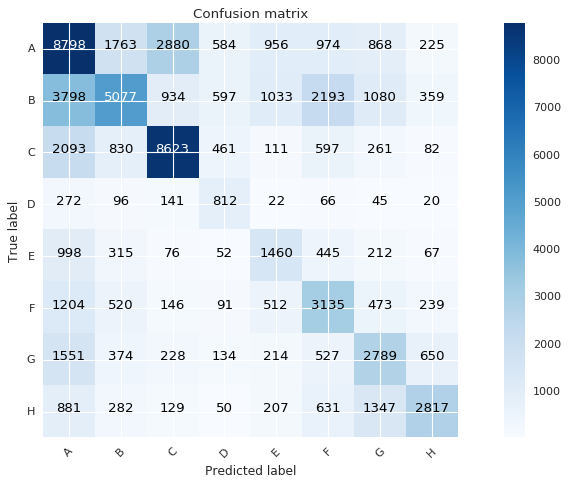

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict

t0 = time()
print('Training Naïve Bayes (Gaussian) model...')
classifier = GaussianNB()
classifier.fit(X_train, y_train)
print('done in %0.3fs.' % (time() - t0))

t0 = time()
print('Predicting classes using Naïve Bayes (Gaussian) model...')
y_pred = classifier.predict(X_test)
print('done in %0.3fs.' % (time() - t0))

# Printing accuracy
acc = accuracy_score(y_test, y_pred)
print('Accuracy: ', str(acc))
comparision = (acc - best_guess[0])/best_guess[0]*100
print('%0.2f%% better than best guess.' % comparision)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
class_names = ['A','B','C','D','E','F','G','H']
plt.figure(figsize=(12,6))
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')
plt.show()

### Naïve Bayes - Bernoulli

Training Naïve Bayes (Bernoulli) model...
done in 8.116s.
Predicting classes using Naïve Bayes (Bernoulli) model...
done in 1.892s.
Accuracy:  0.593657700232
143.72% better than best guess.


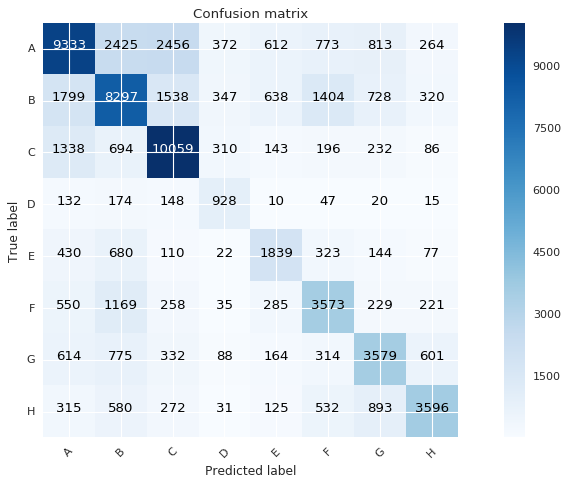

In [10]:
from sklearn.naive_bayes import BernoulliNB

t0 = time()
print('Training Naïve Bayes (Bernoulli) model...')
classifier = BernoulliNB()
classifier.fit(X_train, y_train)
print('done in %0.3fs.' % (time() - t0))

t0 = time()
print('Predicting classes using Naïve Bayes (Bernoulli) model...')
y_pred = classifier.predict(X_test)
print('done in %0.3fs.' % (time() - t0))

# Printing accuracy
acc = accuracy_score(y_test, y_pred)
print('Accuracy: ', str(acc))
comparision = (acc - best_guess[0])/best_guess[0]*100
print('%0.2f%% better than best guess.' % comparision)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
class_names = ['A','B','C','D','E','F','G','H']
plt.figure(figsize=(12,6))
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')
plt.show()

### Random Forest

Training Randon Forest Classifier...


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.3min finished


done in 616.795s.
Predicting classes using Randon Forest Classifier...


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.7s finished


done in 1.046s.
Accuracy:  0.613540420995
151.89% better than best guess.


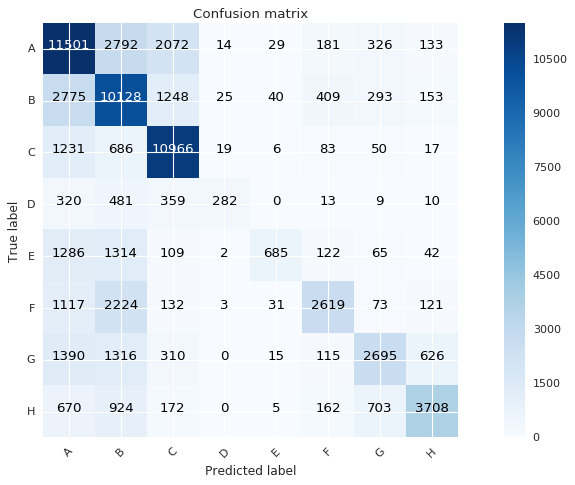

In [11]:
from sklearn.ensemble import RandomForestClassifier

t0 = time()
print('Training Randon Forest Classifier...')
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', n_jobs=-1, verbose=1)
classifier.fit(X_train, y_train)
print('done in %0.3fs.' % (time() - t0))

t0 = time()
print('Predicting classes using Randon Forest Classifier...')
y_pred = classifier.predict(X_test)
print('done in %0.3fs.' % (time() - t0))

# Printing accuracy
acc = accuracy_score(y_test, y_pred)
print('Accuracy: ', str(acc))
comparision = (acc - best_guess[0])/best_guess[0]*100
print('%0.2f%% better than best guess.' % comparision)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
class_names = ['A','B','C','D','E','F','G','H']
plt.figure(figsize=(12,6))
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')
plt.show()

### Multi-layer Perceptron

Training Multi-layer Perceptron Classifier...


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


done in 6673.659s.
Predicting classes using Multi-layer Perceptron Classifier...
done in 2.969s.
Accuracy:  0.660207183713
171.05% better than best guess.


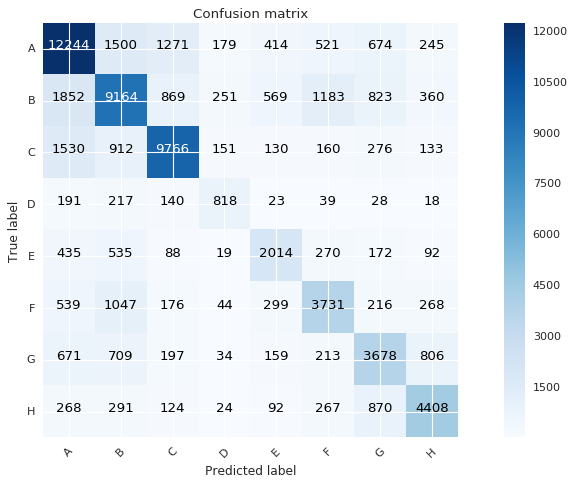

In [12]:
from sklearn.neural_network import MLPClassifier

t0 = time()
print('Training Multi-layer Perceptron Classifier...')
classifier = MLPClassifier(hidden_layer_sizes=(100, 50),
                           verbose=False, max_iter=300)
classifier.fit(X_train, y_train)
print('done in %0.3fs.' % (time() - t0))

t0 = time()
print('Predicting classes using Multi-layer Perceptron Classifier...')
y_pred = classifier.predict(X_test)
print('done in %0.3fs.' % (time() - t0))

# Printing accuracy
acc = accuracy_score(y_test, y_pred)
print('Accuracy: ', str(acc))
comparision = (acc - best_guess[0])/best_guess[0]*100
print('%0.2f%% better than best guess.' % comparision)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
class_names = ['A','B','C','D','E','F','G','H']
plt.figure(figsize=(12,6))
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')
plt.show()